Found existing zip: finer139.zip (skipping download).
Extracted folder already exists: finer139 (skipping extract).
Loading JSONL files (this may take a minute depending on SAMPLE_LIMIT)...
Loaded: train=900384, val=112494, test=108378

Train columns: ['id', 'tokens', 'ner_tags']
Example (first train row):


,tokens_sample,labels_sample
0,"[ITEM, 1, Financial, Statements, Lennar, Corpo...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."



Dataset sizes (records): train=900384, validation=112494, test=108378

Token count statistics (train):
count    900384.000000
mean         45.344541
std          34.912627
min           2.000000
25%          25.000000
50%          37.000000
75%          55.000000
max        1260.000000
Name: token_count, dtype: float64


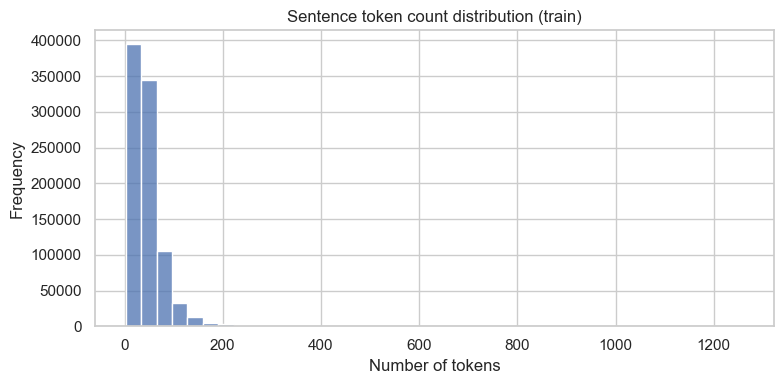


Computing entity frequencies (this may take a few seconds)...

Top 20 entities (train):


,entity,count
0,O,40508701
1,B-DebtInstrumentInterestRateStatedPercentage,15208
2,B-LineOfCreditFacilityMaximumBorrowingCapacity,11693
3,B-DebtInstrumentBasisSpreadOnVariableRate1,11445
4,B-DebtInstrumentFaceAmount,10749
5,B-AllocatedShareBasedCompensationExpense,8710
6,B-AntidilutiveSecuritiesExcludedFromComputatio...,7711
7,B-EffectiveIncomeTaxRateContinuingOperations,7379
8,B-AmortizationOfIntangibleAssets,6421
9,B-ConcentrationRiskPercentage1,5456


C:\Users\lokes\AppData\Local\Temp\ipykernel_29452\516745381.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=label_df.head(top_n), x='count', y='entity', palette="viridis")


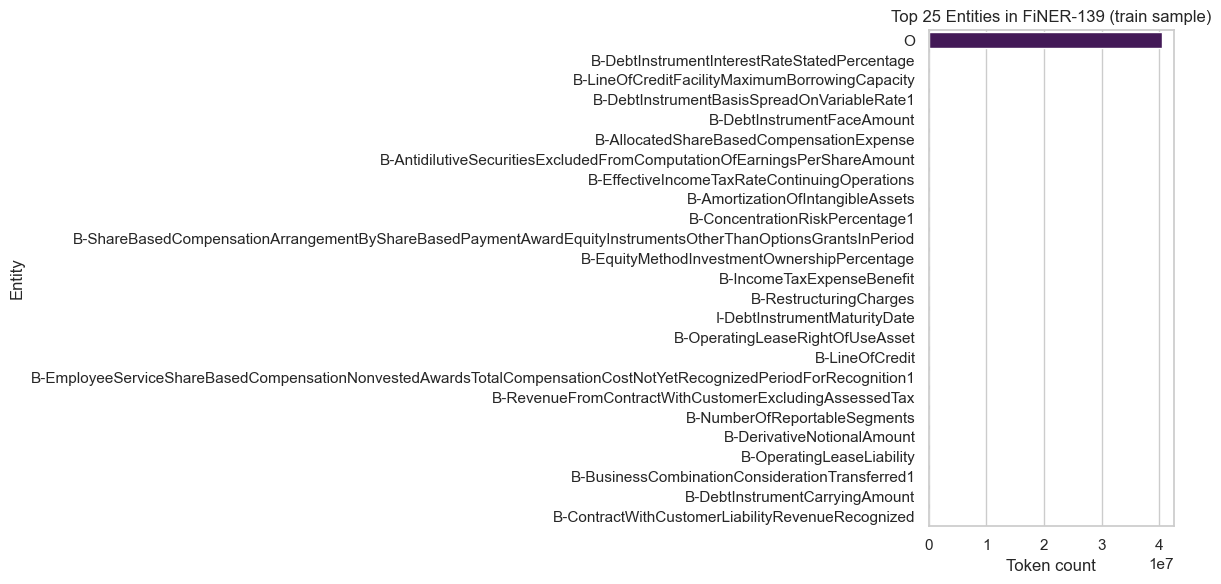


Numeric-looking tokens by label (sample):


,label,count
0,O,198
1,B-IncomeLossFromEquityMethodInvestments,4
2,B-EquityMethodInvestments,4
3,B-BusinessAcquisitionPercentageOfVotingInteres...,1
4,B-UnrecognizedTaxBenefits,1



Examples (token/label) — first 6 rows:
--- example 0 (tokens=327) ---
ITEM/O 1/O Financial/O Statements/O Lennar/O Corporation/O and/O Subsidiaries/O Condensed/O Consolidated/O Balance/O Sheets/O (/O Dollars/O in/O thousands/O ,/O except/O shares/O and/O per/O share/O amounts/O )/O (/O unaudited/O )/O (/O 1/O )/O Under/O certain/O provisions/O of/O Accounting/O Standards/O Codification/O (/O “/O ASC/O ”/O )/O Topic/O 810/O ,/O Consolidations/O ,/O (/O “/O ASC/O 810/O ”/O )/O the/O Company/O is/O required/O to/O separately/O disclose/O

--- example 1 (tokens=174) ---
See/O accompanying/O notes/O to/O condensed/O consolidated/O financial/O statements/O ./O 3/O Lennar/O Corporation/O and/O Subsidiaries/O Condensed/O Consolidated/O Statements/O of/O Operations/O and/O Comprehensive/O Income/O (/O Dollars/O in/O thousands/O ,/O except/O per/O share/O amounts/O )/O (/O unaudited/O )/O See/O accompanying/O notes/O to/O condensed/O consolidated/O financial/O statements/O ./O 4/O Lennar/O Corp

In [2]:
import os, sys, json, zipfile, math
from collections import Counter
from pathlib import Path
required = ["pandas", "matplotlib", "seaborn", "requests", "tqdm"]
import importlib
for pkg in required:
    if importlib.util.find_spec(pkg) is None:
        print(f"Installing missing package: {pkg} ...")
        !{sys.executable} -m pip install --quiet {pkg}
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display

sns.set(style="whitegrid")
%matplotlib inline
DATA_DIR = Path("finer139")
ZIP_PATH = Path("finer139.zip")
DOWNLOAD_URL = "https://huggingface.co/datasets/nlpaueb/finer-139/resolve/main/finer139.zip"
SAMPLE_LIMIT = None   
OUT_DIR = Path("finer139_eda_outputs")
OUT_DIR.mkdir(exist_ok=True)
def download_if_needed(url, zip_path):
    if zip_path.exists() and zip_path.stat().st_size > 1000:
        print(f"Found existing zip: {zip_path} (skipping download).")
        return
    print("Downloading FiNER-139 (this may take ~10-60s depending on your connection)...")
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0)) if r.headers.get("content-length") else None
    with open(zip_path, "wb") as f:
        if total:
            with tqdm(total=total, unit='B', unit_scale=True, desc="download") as pbar:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
                        pbar.update(len(chunk))
        else:
            f.write(r.content)
    print("Download finished:", zip_path)

def extract_if_needed(zip_path, out_dir):
    if out_dir.exists() and any(out_dir.iterdir()):
        print(f"Extracted folder already exists: {out_dir} (skipping extract).")
        return
    print("Extracting zip...")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(out_dir)
    print("Extraction complete. Files:", sorted([p.name for p in out_dir.iterdir()]))
download_if_needed(DOWNLOAD_URL, ZIP_PATH)
extract_if_needed(ZIP_PATH, DATA_DIR)
def stream_load_jsonl(path, limit=None):
    """Load JSONL file line by line. Returns list of dicts (up to limit if set)."""
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if not line.strip():
                continue
            try:
                obj = json.loads(line)
            except Exception as e:
                print(f"JSON decode error on line {i} in {path}: {e}")
                continue
            data.append(obj)
            if limit is not None and len(data) >= limit:
                break
    return data
train_path = DATA_DIR / "train.jsonl"
val_path   = DATA_DIR / "validation.jsonl"
test_path  = DATA_DIR / "test.jsonl"

for p in (train_path, val_path, test_path):
    if not p.exists():
        raise FileNotFoundError(f"Expected file not found: {p}. Make sure extraction succeeded.")
print("Loading JSONL files (this may take a minute depending on SAMPLE_LIMIT)...")
train_data = stream_load_jsonl(train_path, limit=SAMPLE_LIMIT)
val_data   = stream_load_jsonl(val_path,   limit=math.ceil(SAMPLE_LIMIT/5) if SAMPLE_LIMIT else None)
test_data  = stream_load_jsonl(test_path,  limit=math.ceil(SAMPLE_LIMIT/5) if SAMPLE_LIMIT else None)

print(f"Loaded: train={len(train_data)}, val={len(val_data)}, test={len(test_data)}")
train_df = pd.DataFrame(train_data)
val_df   = pd.DataFrame(val_data)
test_df  = pd.DataFrame(test_data)

# Basic sanity check
print("\nTrain columns:", train_df.columns.tolist())
print("Example (first train row):")
if len(train_df) > 0:
    display(pd.DataFrame({
        "tokens_sample": [train_df.loc[0, 'tokens'][:40]],
        "labels_sample": [train_df.loc[0, 'ner_tags'][:40]]
    }))
else:
    print("No training data loaded (SAMPLE_LIMIT may be 0).")

if 'tokens' not in train_df.columns or 'ner_tags' not in train_df.columns:
    raise KeyError("Expected columns 'tokens' and 'ner_tags' not found in the loaded data.")
train_df['token_count'] = train_df['tokens'].apply(lambda t: len(t) if isinstance(t, list) else 0)
print(f"\nDataset sizes (records): train={len(train_df)}, validation={len(val_df)}, test={len(test_df)}")
print("\nToken count statistics (train):")
print(train_df['token_count'].describe())
plt.figure(figsize=(8,4))
sns.histplot(train_df['token_count'], bins=40, kde=False)
plt.title("Sentence token count distribution (train)")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(OUT_DIR / "sentence_length_distribution.png", dpi=150)
plt.show()
print("\nComputing entity frequencies (this may take a few seconds)...")
all_labels = []
for lbls in train_df['ner_tags']:
    if isinstance(lbls, list):
        all_labels.extend(lbls)

label_counts = Counter(all_labels)
label_df = pd.DataFrame(label_counts.items(), columns=['entity','count']).sort_values('count', ascending=False).reset_index(drop=True)
print("\nTop 20 entities (train):")
display(label_df.head(20))
top_n = 25
plt.figure(figsize=(12,6))
sns.barplot(data=label_df.head(top_n), x='count', y='entity', palette="viridis")
plt.title(f"Top {top_n} Entities in FiNER-139 (train sample)")
plt.xlabel("Token count")
plt.ylabel("Entity")
plt.tight_layout()
plt.savefig(OUT_DIR / "top_entities.png", dpi=150)
plt.show()
def looks_like_number(tok):
    if not isinstance(tok, str): 
        return False
    tok_stripped = tok.replace(',', '').replace('$','').replace('€','').replace('%','').replace('₹','')
    try:
        float(tok_stripped)
        return True
    except:
        return any(ch.isdigit() for ch in tok)
numeric_examples = []
for tokens, labels in zip(train_df['tokens'], train_df['ner_tags']):
    if not isinstance(tokens, list) or not isinstance(labels, list): 
        continue
    for t,l in zip(tokens, labels):
        if looks_like_number(t):
            numeric_examples.append((t,l))
    if len(numeric_examples) >= 200:
        break
numeric_df = pd.DataFrame(numeric_examples, columns=['token','label']).groupby(['label']).size().sort_values(ascending=False).reset_index(name='count')
print("\nNumeric-looking tokens by label (sample):")
display(numeric_df.head(20))
def format_example(tokens, labels, max_tokens=80):
    pairs = [f"{tok}/{lab}" for tok,lab in zip(tokens[:max_tokens], labels[:max_tokens])]
    return " ".join(pairs)

print("\nExamples (token/label) — first 6 rows:")
for i in range(min(6, len(train_df))):
    print(f"--- example {i} (tokens={train_df.loc[i,'token_count']}) ---")
    print(format_example(train_df.loc[i,'tokens'], train_df.loc[i,'ner_tags'], max_tokens=60))
    print()
label_df.to_csv(OUT_DIR / "entity_counts_train.csv", index=False)
train_df_sample_out = train_df.head(500).copy()  # save a small sample with tokens and labels for manual review
train_df_sample_out.to_json(OUT_DIR / "train_sample_500.jsonl", orient="records", lines=True, force_ascii=False)
train_df.head(200).to_csv(OUT_DIR / "train_head_200.csv", index=False)

print(f"\n✅ EDA artifacts saved into folder: {OUT_DIR.resolve()}")
print("Files saved:")
for f in sorted(OUT_DIR.iterdir()):
    print(" -", f.name)
total_entities = len(label_df)
top5 = label_df.head(5).to_dict(orient='records')
print("\n--- EDA Summary ---")
print(f"Records loaded (train): {len(train_df)}")
print(f"Unique entity labels found (train): {total_entities}")
print("Top 5 most frequent entities (label:count):")
for r in top5:
    print("  ", r['entity'], ":", r['count'])
print("Saved plots: sentence_length_distribution.png, top_entities.png")
print("\nYou can now attach the CSVs / plots to your report or continue to the modeling step.")
